In [119]:
import sys
print(sys.version)

3.6.3 |Anaconda custom (64-bit)| (default, Oct 13 2017, 12:02:49) 
[GCC 7.2.0]


In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score
pd.options.display.max_seq_items = 2000

# Get the Data!

Import data from UCI Repository 

In [121]:
uris = [
    'http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
    'https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data'
]

df_adult, df_letter = [pd.read_csv(uri, header=None) for uri in uris]

df_covtype = pd.read_csv('covtype.data', header=None)

# Preprocess the Data!

In [122]:
def get_X_and_Y(df):
    X = df.values[:, :-1]
    Y = df.values[:, -1:]
    return (X, Y)

## Inspect the ADULT dataset

In [123]:
# Based on the Data Description in 
# https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names

df_adult.columns = ['age'
                    , 'workclass'
                    , 'fnlwgt'
                    , 'education'
                    , 'education-num'
                    , 'marital-status'
                    , 'occupation'
                    , 'relationship'
                    , 'race'
                    , 'sex'
                    , 'capital-gain'
                    , 'captial-loss'
                    , 'hours-per-week'
                    , 'native-country'
                    , 'income']

In [124]:
df_adult.isnull().values.any()

False

In [125]:
print('Number of rows in ADULT:' + str(len(df_adult)))

df_adult.head()

Number of rows in ADULT:32561


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,captial-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Vectorize categorical columns in ADULT dataset

In [126]:
# len(pd.get_dummies(df_adult).columns)
#print(pd.get_dummies(df_adult).columns)

df_adult = pd.get_dummies(df_adult)

In [127]:
df_adult = df_adult.drop(['sex_ Female', 'income_ <=50K'], axis=1)

In [128]:
df_adult.head()

,age,fnlwgt,education-num,capital-gain,captial-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,...,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,income_ >50K
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Convert to numpy arrays and split

In [129]:
df_adult = df_adult.sample(frac=1)
adult_X, adult_Y = get_X_and_Y(df_adult)

adult_X_train, adult_X_test, adult_Y_train, adult_Y_test = \
 train_test_split(adult_X, adult_Y, test_size=0.33)

In [130]:
# Don't split. rerun classifiers, randomizing train/test split each time. 

print('adult_X_train.shape: ' + str(adult_X_train.shape))
print('adult_Y_train.shape: ' + str(adult_Y_train.shape))
print('adult_X_test.shape : ' + str(adult_X_test.shape))
print('adult_Y_test.shape : ' + str(adult_Y_test.shape))


adult_X_train.shape: (21815, 107)
adult_Y_train.shape: (21815, 1)
adult_X_test.shape : (10746, 107)
adult_Y_test.shape : (10746, 1)


## Inspect the LETTER dataset

In [131]:
print('Number of rows in LETTER: ' + str(len(df_letter)))

df_letter.head()

Number of rows in LETTER: 20000


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [132]:
# Based on the Data Description in 
# https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.names

df_letter.columns = [   'lettr'
                        , 'x-box'
                        , 'y-box'
                        , 'width'
                        , 'high '
                        , 'onpix'
                        , 'x-bar'
                        , 'y-bar'
                        , 'x2bar'
                        , 'y2bar'
                        , 'xybar'
                        , 'x2ybr'
                        , 'xy2br'
                        , 'x-ege'
                        , 'xegvy'
                        , 'y-ege'
                        , 'yegvx']

In [133]:
# In Caruana & Niculescu-Mizil,. 2006, 
# the LETTER.p1 dataset was analyzed with the letter 'O' being the positive case 
# and all else negative. 

df_letter['lettr'] = df_letter['lettr'].map({'O':1}).fillna(0)

In [134]:
df_letter.head()

,lettr,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,0.0,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,0.0,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,0.0,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,0.0,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,0.0,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [135]:
# Make the 'lettr' column last to conform with other datasets. 
cols = df_letter.columns.tolist()
cols = cols[1:-2] + cols[:1]

In [136]:
df_letter = df_letter[cols]

### Convert to numpy array and split

In [137]:
letter_X, letter_Y = get_X_and_Y(df_letter)

letter_X_train, letter_X_test, letter_Y_train, letter_Y_test = \
 train_test_split(letter_X, letter_Y, test_size=0.33)

In [138]:
print('letter_X_train.shape: ' + str(letter_X_train.shape))
print('letter_Y_train.shape: ' + str(letter_Y_train.shape))
print('letter_X_test.shape : ' + str(letter_X_test.shape))
print('letter_Y_test.shape : ' + str(letter_Y_test.shape))

letter_X_train.shape: (13400, 14)
letter_Y_train.shape: (13400, 1)
letter_X_test.shape : (6600, 14)
letter_Y_test.shape : (6600, 1)


## Inspect the COV_TYPE dataset

In [139]:
df_covtype.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [140]:
# Not going to rename columns here, there's way too many.
# According to https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.info
# column 54 is the cover type, which is what we're classifying. 

In [141]:
# In Caruana & Niculescu-Mizil,. 2006, the COV_TYPE dataset 
# was classified with the largest covertype as the positive case, 
# all else negative

df_covtype[54] = df_covtype[54].map({7:1}).fillna(0)

### Convert to numpy array and split

In [142]:
covtype_X, covtype_Y = get_X_and_Y(df_covtype)
covtype_X_train, covtype_X_test, covtype_Y_train, covtype_Y_test = \
 train_test_split(covtype_X, covtype_Y, test_size=0.33)

In [143]:
print('covtype_X_train.shape: ' + str(covtype_X_train.shape))
print('covtype_Y_train.shape: ' + str(covtype_Y_train.shape))
print('covtype_X_test.shape : ' + str(covtype_X_test.shape))
print('covtype_Y_test.shape : ' + str(covtype_Y_test.shape))

covtype_X_train.shape: (389278, 54)
covtype_Y_train.shape: (389278, 1)
covtype_X_test.shape : (191734, 54)
covtype_Y_test.shape : (191734, 1)


In [144]:
dfs = [df_adult, df_letter, df_covtype]

In [145]:
splits = [.8, .5, .2]

# Classifiers!

In [146]:
clf_names = ["Logistic Regression", "KNN", "Random Forest"]
df_names = ["ADULT", "LETTER", "COV_TYPE"]

In [147]:
def run_clf(clf, X_train, Y_train, X_test, Y_test):
    print()
    clf.fit(X_train, Y_train.reshape(-1, ))
    pred = clf.predict(X_test)
    if(hasattr(clf, 'best_params_')):
        results(clf, X_test, Y_test, "test")
    return accuracy_score(Y_test, pred)

In [148]:
param_grid = {'C': [10e-8, 10e-7, 10e-6, 10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 1, 10e1, 10e2, 10e3, 10e4]}
lr = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')

k = np.arange(26) + 1
parameters = {'n_neighbors': k}
knn = neighbors.KNeighborsClassifier()
knn = GridSearchCV(knn,parameters,cv=5)

rf = RandomForestClassifier()
clfs = [lr, knn, rf]

In [150]:
len(df_covtype[df_covtype[54] == 1])

20510

In [152]:
 for df_name, df in zip(df_names, dfs):
    print("Dataset: " + df_name)
    print("...")
    df = df.sample(frac=1) # Shuffle the data
    X, Y = get_X_and_Y(df_covtype) 
    for split in splits:
        print("\t Test Split: " + str(split))
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=split)
        for name, clf in zip(clf_names, clfs):
            print("\t \t Running Classifier: " + name)
            print(run_clf(clf, X_train, Y_train, X_test, Y_test))
            print("...")

Dataset: ADULT
...
	 Test Split: 0.8
	 	 Running Classifier: Logistic Regression

Best parameters for training set of test dataset:

{'C': 1000.0}

Grid scores on development set:

0.965 (+/-0.000) for {'C': 1e-07}
0.964 (+/-0.000) for {'C': 1e-06}
0.964 (+/-0.000) for {'C': 1e-05}
0.965 (+/-0.001) for {'C': 0.0001}
0.969 (+/-0.001) for {'C': 0.001}
0.974 (+/-0.002) for {'C': 0.01}
0.975 (+/-0.001) for {'C': 0.1}
0.976 (+/-0.002) for {'C': 1.0}
0.976 (+/-0.002) for {'C': 1}
0.976 (+/-0.002) for {'C': 100.0}
0.976 (+/-0.002) for {'C': 1000.0}
0.976 (+/-0.001) for {'C': 10000.0}
0.976 (+/-0.002) for {'C': 100000.0}

Accuracy of Logistic Regression on test dataset

0.975194165358

0.975194165358
...
	 	 Running Classifier: KNN



KeyboardInterrupt: 

# Logistic Regression

In [24]:
def results(clf, x_test, y_test, dataset_name):
    print("Best parameters for training set of " + dataset_name + " dataset:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    
    plt.semilogx()
#     for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, params))
    print()
    print("Accuracy of Logistic Regression on " + dataset_name + " dataset")
    print()
    y_true, y_pred = y_test, clf.predict(x_test)
    print(accuracy_score(y_true, y_pred))
    print()

In [176]:
param_grid = {'C': [10e-8, 10e-7, 10e-6, 10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 1, 10e1, 10e2, 10e3, 10e4]}
#param_grid = {'C': [10e-8, 10e4]}
clf = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
clf

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 1, 100.0, 1000.0, 10000.0, 100000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)


## ADULT Dataset

In [177]:
run_clf(clf, adult_X_train, adult_Y_train, adult_X_test, adult_Y_test)


Best parameters for training set of test dataset:

{'C': 0.1}

Grid scores on development set:

0.795 (+/-0.007) for {'C': 1e-07}
0.795 (+/-0.008) for {'C': 1e-06}
0.797 (+/-0.007) for {'C': 1e-05}
0.797 (+/-0.007) for {'C': 0.0001}
0.797 (+/-0.007) for {'C': 0.001}
0.797 (+/-0.007) for {'C': 0.01}
0.797 (+/-0.007) for {'C': 0.1}
0.797 (+/-0.007) for {'C': 1.0}
0.797 (+/-0.007) for {'C': 1}
0.797 (+/-0.007) for {'C': 100.0}
0.797 (+/-0.007) for {'C': 1000.0}
0.797 (+/-0.007) for {'C': 10000.0}
0.797 (+/-0.007) for {'C': 100000.0}

Accuracy of Logistic Regression on test dataset

0.800018611576



0.80001861157640053

[1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 1, 100.0, 1000.0, 10000.0, 100000.0]


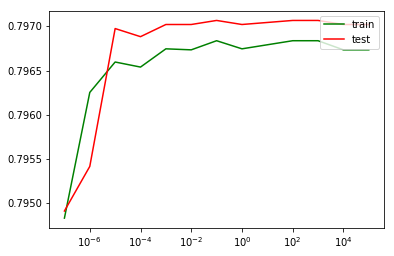

In [190]:
clf.cv_results_
#[d['value'] for d in l]
p = clf.cv_results_['params']
print([list(d.values())[0] for d in p])
plt.semilogx([list(d.values())[0] for d in p], clf.cv_results_['mean_train_score'], 'g', label='train')
plt.semilogx([list(d.values())[0] for d in p], clf.cv_results_['mean_test_score'], 'r', label='test')
plt.legend(loc = 'upper right')
plt.show()

## LETTER Dataset

In [69]:
run_clf(clf, letter_X_train, letter_Y_train, letter_X_test, letter_Y_test)

Best parameters for training set of test dataset:

{'C': 1e-07}

Grid scores on development set:

0.962 (+/-0.000) for {'C': 1e-07}
0.962 (+/-0.000) for {'C': 1e-06}
0.962 (+/-0.000) for {'C': 1e-05}
0.962 (+/-0.000) for {'C': 0.0001}
0.962 (+/-0.000) for {'C': 0.001}
0.962 (+/-0.000) for {'C': 0.01}
0.962 (+/-0.000) for {'C': 0.1}
0.962 (+/-0.001) for {'C': 1.0}
0.962 (+/-0.001) for {'C': 1}
0.962 (+/-0.001) for {'C': 100.0}
0.962 (+/-0.001) for {'C': 1000.0}
0.962 (+/-0.001) for {'C': 10000.0}
0.962 (+/-0.001) for {'C': 100000.0}

Accuracy of Logistic Regression on test dataset

0.962424242424



0.9624242424242424

## COV_TYPE Dataset

In [71]:
run_clf(clf, covtype_X_train, covtype_Y_train, covtype_X_test, covtype_Y_test)

Best parameters for training set of test dataset:

{'C': 100000.0}

Grid scores on development set:

0.964 (+/-0.000) for {'C': 1e-07}
0.964 (+/-0.000) for {'C': 1e-06}
0.964 (+/-0.001) for {'C': 1e-05}
0.966 (+/-0.001) for {'C': 0.0001}
0.972 (+/-0.001) for {'C': 0.001}
0.975 (+/-0.001) for {'C': 0.01}
0.975 (+/-0.002) for {'C': 0.1}
0.976 (+/-0.001) for {'C': 1.0}
0.976 (+/-0.001) for {'C': 1}
0.975 (+/-0.002) for {'C': 100.0}
0.976 (+/-0.001) for {'C': 1000.0}
0.976 (+/-0.001) for {'C': 10000.0}
0.976 (+/-0.001) for {'C': 100000.0}

Accuracy of Logistic Regression on test dataset

0.976436104186



0.97643610418600768

In [30]:
#clf.fit(covtype_X_train, covtype_Y_train.reshape(-1, ))

In [31]:
#results(clf, covtype_X_test, covtype_Y_test, "COV_TYPE")

# KNN

In [182]:
k = np.arange(5) + 1
parameters = {'n_neighbors': k}
knn = neighbors.KNeighborsClassifier()
knn = GridSearchCV(knn,parameters,cv=5)
#clf = neighbors.KNeighborsClassifier(3)

## Adult

In [183]:
run_clf(knn, adult_X_train, adult_Y_train, adult_X_test, adult_Y_test)


Best parameters for training set of test dataset:

{'n_neighbors': 4}

Grid scores on development set:

0.723 (+/-0.010) for {'n_neighbors': 1}
0.782 (+/-0.008) for {'n_neighbors': 2}
0.754 (+/-0.007) for {'n_neighbors': 3}
0.789 (+/-0.005) for {'n_neighbors': 4}
0.775 (+/-0.007) for {'n_neighbors': 5}

Accuracy of Logistic Regression on test dataset

0.790805881258



0.79080588125814255

In [186]:
knn.cv_results_['mean_train_score']

array([ 1.        ,  0.86647947,  0.86108182,  0.83015124,  0.82847811])

[1, 2, 3, 4, 5]


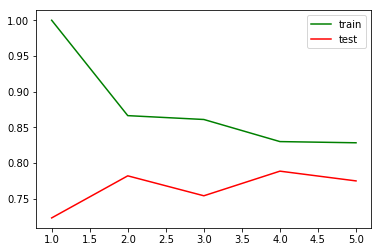

In [189]:
knn.cv_results_
#[d['value'] for d in l]
p = knn.cv_results_['params']
print([list(d.values())[0] for d in p])
plt.plot([list(d.values())[0] for d in p], knn.cv_results_['mean_train_score'], 'g', label='train')
plt.plot([list(d.values())[0] for d in p], knn.cv_results_['mean_test_score'], 'r', label='test')
plt.legend(loc = 'upper right')
plt.show()

## LETTER

In [94]:
run_clf(clf, letter_X_train, letter_Y_train, letter_X_test, letter_Y_test)

0.9906060606060606

## COV_TYPE

In [95]:
run_clf(clf, covtype_X_train, covtype_Y_train, covtype_X_test, covtype_Y_test)

0.99766342954301268

# Random Forest

In [60]:
clf = RandomForestClassifier()

## ADULT

In [61]:
run_RF(clf, adult_X_train, adult_Y_train, adult_X_test, adult_Y_test)

0.84961846268378927

## LETTER

In [62]:
run_RF(clf, letter_X_train, letter_Y_train, letter_X_test, letter_Y_test)

0.98984848484848487

## COV_TYPE

In [63]:
run_RF(clf, covtype_X_train, covtype_Y_train, covtype_X_test, covtype_Y_test)

0.99599445064516468